# Speedup Pandas

- Make Your Pandas Code Lightning Fast
https://www.youtube.com/watch?v=SAFmrTnEHLg

In [1]:
import pandas as pd
import numpy as np

# Creating our Dataset

In [2]:
def get_dataset(size=10_000):
    df = pd.DataFrame()
    df['age'] = np.random.randint(0, 100, size)
    df['time_in_bed'] = np.random.randint(0, 9, size)
    df['pct_sleeping'] = np.random.rand(size)
    df['favorite_food'] = np.random.choice(['pizza','taco','ice-cream'], size)
    df['hate_food'] = np.random.choice(['broccoli','candy corn','eggs'], size)
    return df

In [3]:
df = get_dataset()
df.head()

age  time_in_bed  pct_sleeping favorite_food   hate_food
0   46            8      0.197611         pizza  candy corn
1   61            3      0.650057          taco        eggs
2   35            3      0.009105          taco    broccoli
3   34            6      0.301315         pizza        eggs
4   36            3      0.440809         pizza    broccoli

# The Problem

Reward calculation:

- If they were in bed for more than 5 hours AND they were sleeping for more than 50%, we give them their favorite food.
- Otherwise, we give them their hate food.
- If they are over 90 years old, give their favorite food regardless.

In [4]:
# 重點是設計不同case，每個case都要回傳對應的值
def reward_cal(row):
    if row['age'] >= 90:
        return row['favorite_food']
    if (row['time_in_bed'] > 5) & (row['pct_sleeping'] > 0.5):
        return row['favorite_food']
    return row['hate_food']

# Level 1 - Loop

In [5]:
%%timeit
df = get_dataset()
for index, row in df.iterrows():
    df.loc[index, 'reward'] = reward_cal(row)

1.04 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Level 2 - Apply

In [6]:
%%timeit
df = get_dataset()
df['reward'] = df.apply(reward_cal, axis=1)

80.4 ms ± 651 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Level 3 - Swifter

In [18]:
# !pip install -U pandas
# !pip install -U swifter
# !pip install -U swifter[groupby]
# import swifter

In [19]:
# %%timeit
# df = get_dataset()
# df['reward'] = df.swifter.apply(reward_cal, axis=1)

# Level 4 - Vectorized

In [22]:
((df['pct_sleeping'] > 0.5) & (df['time_in_bed'] > 5)) | (df['age'] > 90)

0       False
1       False
2       False
3       False
4        True
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [24]:
%%timeit
df = get_dataset()
df['reward'] = df['hate_food']
df.loc[((df['pct_sleeping'] > 0.5) & 
        (df['time_in_bed'] > 5)) | 
       (df['age'] > 90), 'reward'] = df['favorite_food']

4.23 ms ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Plot Differences

In [25]:
results = pd.DataFrame(
    [
        ["loop", 3580, 48.3],
        ["apply", 192, 6.34],
        ["vectorized", 1.36, 0.00896],
    ],
    columns=['type','mean','std'],
)

<AxesSubplot:title={'center':'Time to Run Reward Calc'}, xlabel='type'>

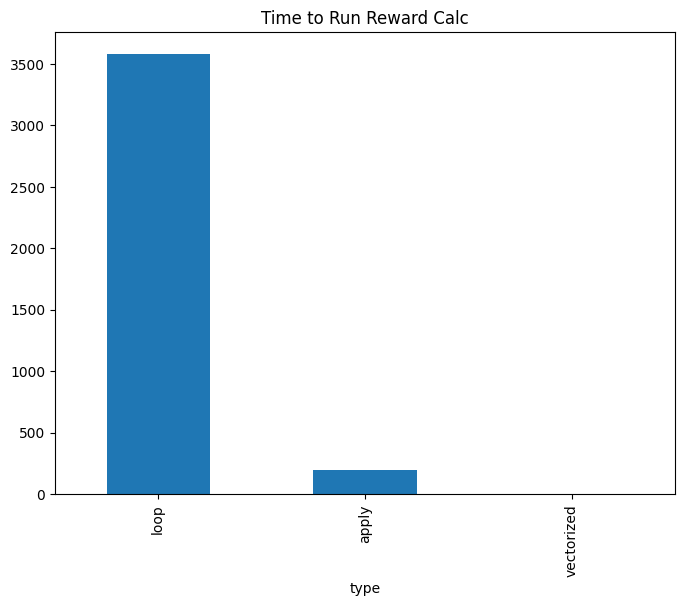

: 

In [34]:
results.set_index('type')['mean'].plot(kind='bar', title='Time to Run Reward Calc', figsize=(8, 6))